## Introduction

This report aims to explore the application of survival models to predict no-show rates for hotel bookings. This initiative is inspired by platforms like Booking.com [1] and a keen interest in the robust capabilities of survival models. These models stand out for their ability to not only predict the occurrence of an event but also incorporate the dimension of time, thus accounting for events that may or may not happen over a given period.

### Core Strength of Survival Models

Survival models bring a unique perspective to forecasting by considering the timing of an event in the analysis. To illustrate, consider two scenarios involving hotel bookings:

__Scenario 1__: A booking is made two weeks in advance. Assuming the individual has a reliable history, the probability of a no-show (X) is relatively low, barring unforeseen circumstances.

__Scenario 2__: A booking is made nine months in advance. Intuitively, the probability of a no-show (Y) in this scenario would be higher than in Scenario 1, given the increased likelihood of intervening events over a longer time span.

Conventional machine learning models might treat these scenarios similarly, factoring in the booking lead time but potentially overlooking the nuanced differences in no-show risk as the travel date approaches. This is where survival models excel, as they can dynamically adjust the risk assessment over time, offering a more nuanced and accurate prediction.

### Application of Survival Models in the Context of Hotel Bookings

Survival models can evaluate the day-to-day probability of a booking cancellation, providing a timeline of risk assessment. This approach allows businesses to take preemptive actions at critical junctures, potentially influencing the outcome (e.g., reducing the likelihood of a no-show). Moreover, the impact of these interventions can be fed back into the model to find optimal strategies. Finally, we can also optimise occupancy, when we forecast a no-show accurately.

Such models are particularly adept at handling 'censored' data — instances where the outcome (in this case, a no-show) hasn't occurred by the end of the observation period but could occur in the future. This capability is crucial for accurately modelling no-show rates, as it allows for including all bookings, regardless of their current status.
Dataset Source

The dataset utilised for this analysis originates from the article "Hotel Booking Demand Datasets" by Nuno Antonio, Ana Almeida, and Luis Nunes [2]. Thomas Mock and Antoine Bichat prepared and cleaned this dataset for #TidyTuesday during the week of February 11th, 2020 [3], and it was accessed through Kaggle datasets [4]. You can find the latest version of this notebook on GitHub [5].

1: https://youtu.be/Fa3Ha6QYp3o (also at meetups they talk about these models in different use cases) \
2: https://www.sciencedirect.com/science/article/pii/S2352340918315191 \
3: https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md \
4: https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand \
5: https://github.com/jjzd83/SML

In [1]:
%matplotlib inline
# Standard library imports
from datetime import timedelta

# Data handling and numerical computing
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports for machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import validation_curve

# Survival analysis libraries from scikit-survival
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.util import Surv


C:\Users\jjzd8\AppData\Local\Temp\ipykernel_13748\2486178730.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


We will use only the dataset from the resort hotel, not the city hotel. The characteristics are different in the population and did not generailise well. I will leave the second dataset in, so you can explore for yourself

In [46]:
df_h1 = pd.read_csv("data/H1.csv")
df_h1.shape

(40060, 31)

We have in total 400060 records, with 31 columns. Here after the full table of these columns. In summary:

- 3 boolean fields (eg: is cancelled)
- 5 fields to do with dates (eg: arrival week)
- 11 category strings (eg: type of room)
- 12 number fields (eg: number of special requests)

|variable                       |class     |description |
|:------------------------------|:---------|:-----------|
|is_canceled                    |double    | Value indicating if the booking was canceled (1) or not (0) |
|lead_time                      |double    | Number of days that elapsed between the entering date of the booking into the PMS and the arrival date |
|arrival_date_year              |double    | Year of arrival date|
|arrival_date_month             |character | Month of arrival date|
|arrival_date_week_number       |double    | Week number of year for arrival date|
|arrival_date_day_of_month      |double    | Day of arrival date|
|stays_in_weekend_nights        |double    | Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel |
|stays_in_week_nights           |double    |  Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel|
|adults                         |double    | Number of adults|
|children                       |double    | Number of children|
|babies                         |double    |Number of babies |
|meal                           |character | Type of meal booked. Categories are presented in standard hospitality meal packages: <br> Undefined/SC – no meal package;<br>BB – Bed & Breakfast; <br> HB – Half board (breakfast and one other meal – usually dinner); <br> FB – Full board (breakfast, lunch and dinner) |
|country                        |character | Country of origin. Categories are represented in the ISO 3155–3:2013 format |
|market_segment                 |character | Market segment designation. In categories, the term "TA" means "Travel Agents" and "TO" means "Tour Operators" |
|distribution_channel           |character | Booking distribution channel. The term "TA" means "Travel Agents" and "TO" means "Tour Operators" |
|is_repeated_guest              |double    | Value indicating if the booking name was from a repeated guest (1) or not (0) |
|previous_cancellations         |double    | Number of previous bookings that were cancelled by the customer prior to the current booking |
|previous_bookings_not_canceled |double    | Number of previous bookings not cancelled by the customer prior to the current booking |
|reserved_room_type             |character | Code of room type reserved. Code is presented instead of designation for anonymity reasons |
|assigned_room_type             |character | Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons |
|booking_changes                |double    | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation|
|deposit_type                   |character | Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories:<br>No Deposit – no deposit was made;<br>Non Refund – a deposit was made in the value of the total stay cost;<br>Refundable – a deposit was made with a value under the total cost of stay. |
|agent                          |character | ID of the travel agency that made the booking |
|company                        |character | ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons |
|days_in_waiting_list           |double    | Number of days the booking was in the waiting list before it was confirmed to the customer |
|customer_type                  |character | Type of booking, assuming one of four categories:<br>Contract - when the booking has an allotment or other type of contract associated to it;<br>Group – when the booking is associated to a group;<br>Transient – when the booking is not part of a group or contract, and is not associated to other transient booking;<br>Transient-party – when the booking is transient, but is associated to at least other transient booking|
|adr                            |double    | Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights |
|required_car_parking_spaces    |double    | Number of car parking spaces required by the customer |
|total_of_special_requests      |double    | Number of special requests made by the customer (e.g. twin bed or high floor)|
|reservation_status             |character | Reservation last status, assuming one of three categories:<br>Canceled – booking was canceled by the customer;<br>Check-Out – customer has checked in but already departed;<br>No-Show – customer did not check-in and did inform the hotel of the reason why |
|reservation_status_date        |double    | Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel|


One __critical remark made by the original authors:__ Some of the fields are only filled in with arriving guests, so using these fields to forecast the arrival is very easy, but does not represent a realistic solution.

## Data exploration
Let's see what we can discover about the current data

In [ ]:
# Some initial clean-ups
# Room type shows too much whitespace, let's clean it up:
df_h1['ReservedRoomType'] = df_h1['ReservedRoomType'].str.strip()

# Roomtype P has only two bookings, both of them cancelled. Let's drop them
df_h1 = df_h1.loc[df_h1['ReservedRoomType'] != 'P']

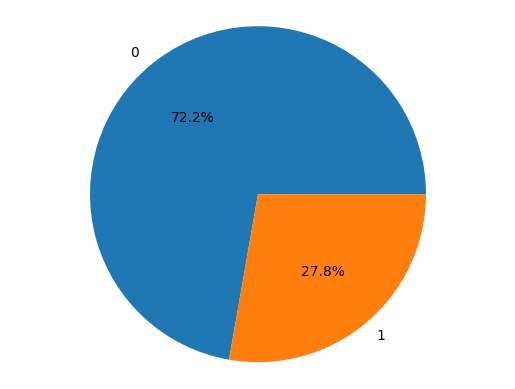

In [3]:
value_counts = df_h1['IsCanceled'].value_counts()
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
plt.axis('equal')  # Ensures the pie chart is circular
plt.show()

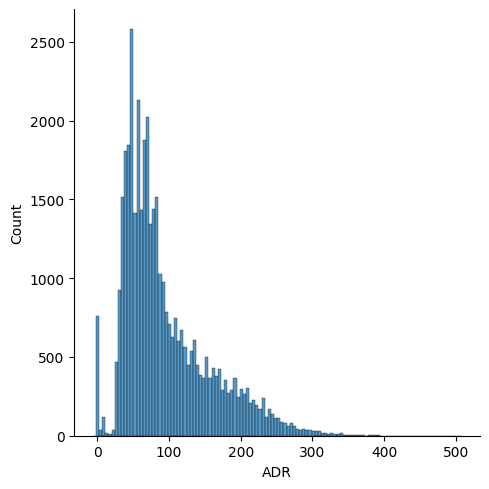

In [4]:
# Average daily rate is the price paid per night.
sns.displot(df_h1['ADR'])

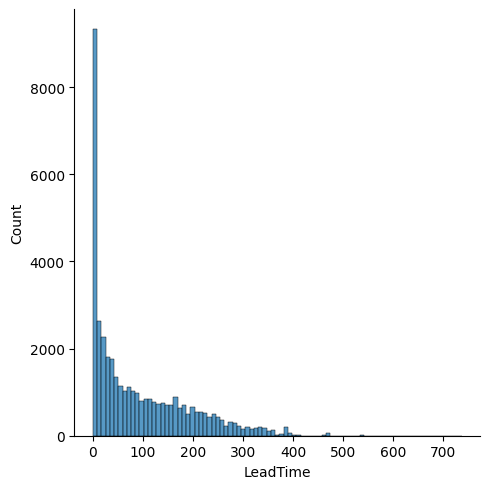

In [5]:
# How far out are the bookings made?
sns.displot(df_h1['LeadTime'])

In [6]:
df_h1

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,...,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,...,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,...,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,0,212,2017,August,35,31,2,8,2,1,...,No Deposit,143,NULL,0,Transient,89.75,0,0,Check-Out,2017-09-10
40056,0,169,2017,August,35,30,2,9,2,0,...,No Deposit,250,NULL,0,Transient-Party,202.27,0,1,Check-Out,2017-09-10
40057,0,204,2017,August,35,29,4,10,2,0,...,No Deposit,250,NULL,0,Transient,153.57,0,3,Check-Out,2017-09-12
40058,0,211,2017,August,35,31,4,10,2,0,...,No Deposit,40,NULL,0,Contract,112.80,0,1,Check-Out,2017-09-14


## EDA - Correlation with cancellations

In [7]:
# Let's find out some correlations
df_h1.corr(numeric_only=True)['IsCanceled'].sort_values()

RequiredCarParkingSpaces      -0.243848
BookingChanges                -0.114811
IsRepeatedGuest               -0.103552
TotalOfSpecialRequests        -0.101241
PreviousBookingsNotCanceled   -0.076760
DaysInWaitingList             -0.036297
Babies                        -0.023246
ArrivalDateDayOfMonth         -0.009406
ArrivalDateWeekNumber          0.021598
ArrivalDateYear                0.043640
StaysInWeekNights              0.078588
StaysInWeekendNights           0.078660
Adults                         0.080781
Children                       0.081263
ADR                            0.109455
PreviousCancellations          0.114186
LeadTime                       0.229541
IsCanceled                     1.000000
Name: IsCanceled, dtype: float64

Here we can see the first type of relations between the chance of cancellation and other qualities:
- Leadtime, amount of previous cancellations and a higher price have the biggest impact
- From there also larger groups or longer stays are positively related
- Factors that seem minimally correlated are dates.

The factors that make a chance smaller for a cancellation are:
- A repeating customer
- The previous reservation was cancelled

The fields that have the highest impact are probably due to them being filled in on the day of arrival, like the required parking spaces and booking changes.

Since leadtime seems to be the largest prediction, let's find out what leads to a further ahead scheduled holliday:

In [8]:
df_h1.corr(numeric_only=True)['LeadTime'].sort_values()

RequiredCarParkingSpaces      -0.151215
IsRepeatedGuest               -0.150063
PreviousBookingsNotCanceled   -0.108313
ArrivalDateDayOfMonth         -0.024378
TotalOfSpecialRequests        -0.007865
Children                       0.000626
Babies                         0.001251
ADR                            0.030411
ArrivalDateYear                0.059243
BookingChanges                 0.075300
DaysInWaitingList              0.089243
PreviousCancellations          0.093953
ArrivalDateWeekNumber          0.121460
Adults                         0.136645
IsCanceled                     0.229541
StaysInWeekendNights           0.325679
StaysInWeekNights              0.387572
LeadTime                       1.000000
Name: LeadTime, dtype: float64

From here we can see when customers book ahead further:
- Longer stays
- More adults

Since both more nights in the weekend and the weekend both contribute, let's merge these, to find out if the total duration has an even bigger influence

In [9]:
df_h1['TotalNightsStay']= df_h1["StaysInWeekendNights"] + df_h1["StaysInWeekNights"]
df_h1.corr(numeric_only=True)['LeadTime'].sort_values()

RequiredCarParkingSpaces      -0.151215
IsRepeatedGuest               -0.150063
PreviousBookingsNotCanceled   -0.108313
ArrivalDateDayOfMonth         -0.024378
TotalOfSpecialRequests        -0.007865
Children                       0.000626
Babies                         0.001251
ADR                            0.030411
ArrivalDateYear                0.059243
BookingChanges                 0.075300
DaysInWaitingList              0.089243
PreviousCancellations          0.093953
ArrivalDateWeekNumber          0.121460
Adults                         0.136645
IsCanceled                     0.229541
StaysInWeekendNights           0.325679
StaysInWeekNights              0.387572
TotalNightsStay                0.392798
LeadTime                       1.000000
Name: LeadTime, dtype: float64

And indeed, the total duration of the stay is even more correlated than the individual components. We will keep the original columns to keep the possibility open that the characteristics of week and weekend guests are different, even accounting for duration.

## Price per night
Let's find out what contributes to a higher daily rate

In [10]:
df_h1.corr(numeric_only=True)['ADR'].sort_values()

IsRepeatedGuest               -0.106181
PreviousBookingsNotCanceled   -0.083941
PreviousCancellations         -0.043407
DaysInWaitingList             -0.014195
LeadTime                       0.030411
BookingChanges                 0.030782
ArrivalDateDayOfMonth          0.040721
Babies                         0.053365
RequiredCarParkingSpaces       0.096095
StaysInWeekendNights           0.103533
IsCanceled                     0.109455
StaysInWeekNights              0.119486
TotalNightsStay                0.122159
ArrivalDateYear                0.127785
ArrivalDateWeekNumber          0.157088
TotalOfSpecialRequests         0.185221
Adults                         0.202264
Children                       0.355781
ADR                            1.000000
Name: ADR, dtype: float64

Having more children, more adults or later in the year adds to the price, but also the total amount of nights.

But there is a snag in using the daily rate as input for a chance of calculation. Can we say people who paid more for the same room are more likely to cancel, or are the people staying in more expensice rooms more likely to cancel? Let's find out!

In [11]:
# Let's put every reservation in their own columns
room_dummies = pd.get_dummies(df_h1['ReservedRoomType'])
room_dummies.replace(0, None, inplace=True)
room_dummies.columns = ['R_A', 'R_B', 'R_C', 'R_D', 'R_E', 'R_F', 
                        'R_G', 'R_H', 'R_L']

# Now we have a mask, we can use to multiply by rate, and the rate paid ends up in the column for the room
df_h1_prices = room_dummies * df_h1['ADR'].values.reshape(df_h1.shape[0],1)
df_h1_prices.replace(0, None, inplace=True)

# from here we can remove all zeros (so we have a proper median, and then calculate what the customer paid relative to the median)
column_medians = df_h1_prices.median()
relative_prices = df_h1_prices.div(column_medians)
df_h1['relative_price'] = relative_prices.sum(axis=1).astype(float)

# Did we improve something?
df_h1.corr(numeric_only=True)['relative_price'].sort_values()




IsRepeatedGuest               -0.093043
PreviousBookingsNotCanceled   -0.068059
PreviousCancellations         -0.028426
DaysInWaitingList              0.000016
BookingChanges                 0.010649
Babies                         0.033707
Children                       0.033862
ArrivalDateDayOfMonth          0.040221
LeadTime                       0.041503
RequiredCarParkingSpaces       0.050006
StaysInWeekendNights           0.066882
TotalNightsStay                0.086256
StaysInWeekNights              0.087270
IsCanceled                     0.090133
ArrivalDateYear                0.093063
Adults                         0.144119
ArrivalDateWeekNumber          0.161250
TotalOfSpecialRequests         0.177544
ADR                            0.827794
relative_price                 1.000000
Name: relative_price, dtype: float64

Indeed a higher relative price means a higher chance of cancelation.

In [12]:
# Now we don't need the ADR, their reserved or assigned room type anymore:
df_h1.drop(columns=['ADR', 'AssignedRoomType','ReservedRoomType' ], inplace=True)

df_h1['relative_price_bin'] = pd.qcut(df_h1['relative_price'], 5, labels=range(5)).astype(int)


## High season
A relative high price can also mean a high occupancy rate. Some very popular weeks, might make the chance of people booking somewhere else too higher. Let's see what we can detect in the data

In [13]:
df_h1['ArrivalDateYearWeek']= df_h1["ArrivalDateYear"].astype(str) +"-"+ df_h1["ArrivalDateWeekNumber"].astype(str)
bookings_df = pd.DataFrame(df_h1['ArrivalDateYearWeek'].value_counts()).reset_index()
bookings_df.columns=['ArrivalDateYearWeek', 'Bookings']
bookings_df['Bookings'].min(), bookings_df['Bookings'].max(), bookings_df['Bookings'].mean()

(85, 575, 348.3304347826087)

From above code we can learn the median occupancy is 348 bookins, with a high of 575 and a minimum of 85.
Let's split the occupance by 20 percentiles, so we can find out if it is exceptionally busy or quiet, which might explain the raltive price difference. Doing this by percentile makes the calculations later easier.

In [14]:
# We will make this
bookings_df['Bookings_bin'] = pd.qcut(bookings_df['Bookings'], 5, labels=range(5)).astype(int)
bookings_df.drop(columns=['Bookings'], inplace=True)

In [15]:
df_h1 = df_h1.merge(bookings_df, on='ArrivalDateYearWeek')

In [16]:
df_h1.corr(numeric_only=True)['IsCanceled'].sort_values()

RequiredCarParkingSpaces      -0.243848
BookingChanges                -0.114811
IsRepeatedGuest               -0.103552
TotalOfSpecialRequests        -0.101241
PreviousBookingsNotCanceled   -0.076760
DaysInWaitingList             -0.036297
Babies                        -0.023246
ArrivalDateDayOfMonth         -0.009406
ArrivalDateWeekNumber          0.021598
ArrivalDateYear                0.043640
StaysInWeekNights              0.078588
StaysInWeekendNights           0.078660
Adults                         0.080781
Children                       0.081263
TotalNightsStay                0.083934
relative_price                 0.090133
relative_price_bin             0.100460
Bookings_bin                   0.102102
PreviousCancellations          0.114186
LeadTime                       0.229541
IsCanceled                     1.000000
Name: IsCanceled, dtype: float64

And indeed, when it is busy-er in the hoytel, the chance of cancellations also goes up!

## Standardising data
We will clean up some more of the columns in order to do a better investigation to the relations, beyond correlations. We will calcuate the bin for lead time (how far away the booking was made) and if there is an agent involved. The company also gets dropped, it has too many entries and correlates with agent.

In [17]:
# Lets's put the different ead times in different buckets:
df_h1['LeadTime_bin'] = pd.qcut(df_h1['LeadTime'], 5, labels=range(5)).astype(int)

# Let's also clean up the agent field:
df_h1['hasAgent'] = df_h1['Agent']!='       NULL'

df_h1.drop(columns = ['Agent', 'Company', ], inplace=True)

## Fields filled in on arrival

The authors have stated some fields are only filled in on arrival. Let's look for them, and drop them

In [18]:
# First the numeric columns
df_h1.groupby('IsCanceled').mean(numeric_only=True)

,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,...,BookingChanges,DaysInWaitingList,RequiredCarParkingSpaces,TotalOfSpecialRequests,TotalNightsStay,relative_price,relative_price_bin,Bookings_bin,LeadTime_bin,hasAgent
IsCanceled,,,,,,,,,,,,,,,,,,,,,
0,78.837618,2016.101908,26.953314,15.872935,1.133907,3.008985,1.832331,0.106262,0.015620,0.057606,...,0.339692,0.694934,0.191133,0.670883,4.142892,1.153226,1.908874,2.219677,1.744557,0.765430
1,128.703687,2016.172302,27.628777,15.686331,1.335522,3.440917,1.958094,0.187050,0.009442,0.009982,...,0.153417,0.092806,0.000000,0.486871,4.776439,1.297824,2.226349,2.532914,2.621763,0.872392


Clearly the required car parking has no entries when the bookjing is cancelled, so it can go.

In order to check the reservations that have strings in them, i wrote a function to compare the different entries

In [19]:
def find_ratios(column, entry_s):
    # returns the ratio between how many times the string is used in non-cancelled or cancelled bookings
    r1 = sum((df_h1[column] == entry_s) & (df_h1['IsCanceled'] == 0))/sum((df_h1['IsCanceled'] == 0))
    r2 = sum((df_h1[column] == entry_s) & (df_h1['IsCanceled'] == 1))/sum((df_h1['IsCanceled'] == 1))
    if r2 > 0:
        return entry_s, r1/r2

In [20]:
for meal in df_h1.Meal.unique():
    print(find_ratios('Meal', meal))

('BB       ', 1.0858329353129428)
('FB       ', 0.26976955636608946)
('HB       ', 0.8296426110947079)
('SC       ', 31.89439491326284)
('Undefined', 1.1863994737724781)


In [21]:
# For country the value PRT is used very often, but twice as much on arrived guests. So, we can remove this field as well
df_h1.Country.value_counts()

Country
PRT    17630
GBR     6814
ESP     3957
IRL     2166
FRA     1611
       ...  
BIH        1
MUS        1
COM        1
UGA        1
DJI        1
Name: count, Length: 125, dtype: int64

In [22]:
df_h1.drop(columns=['Country', 'Meal', 'RequiredCarParkingSpaces'], inplace=True)

Finally some final clean up to make sure all the fields have their correct types

In [23]:
df_h1['hasCancelations'] = df_h1.PreviousCancellations > 0
df_h1['hasShown'] = df_h1.PreviousBookingsNotCanceled > 0
df_h1.drop(columns=['PreviousBookingsNotCanceled','PreviousCancellations', 'IsRepeatedGuest'], axis=1, inplace=True)
df_h1['IsCanceled'] = df_h1['IsCanceled'].astype(bool)

In [24]:
df_h1['ArrivalDate'] = pd.to_datetime(df_h1.ArrivalDateYear.astype(str) +"/" +  df_h1.ArrivalDateMonth +"/" + df_h1.ArrivalDateDayOfMonth.astype(str))
df_h1.ArrivalDateMonth = df_h1['ArrivalDate'].dt.month
df_h1['ArrivalDayOfWeek'] = df_h1['ArrivalDate'].dt.day_name()

In [25]:
# there is no field as bookingsdate, but there is leadtime, defined as the days entered before the arrival date
df_h1['BookingDate'] = df_h1['ArrivalDate'] - pd.to_timedelta(df_h1['LeadTime'],'d')

df_h1['ReservationStatusDate'] = pd.to_datetime(df_h1['ReservationStatusDate'] )

There is some logic involved, where the reservationStatusDate is the date of the last update. If all went well, this will be the entry where the customer has checked out, but in case of a cancellation, this date will be the day it was cancelled.

We will use this date to calculate how far into the trail the customer cancelled.
If the customer did not cancel, the lead time to checkin will be lower than the reservation update date, and we use that value. 

In [26]:
df_h1['EventDays'] = (df_h1['ReservationStatusDate'] - df_h1['BookingDate']).dt.days
df_h1['EventDays']= df_h1[["LeadTime", 'EventDays']].min(axis=1)

## Modelling
We have everything in place now to start the modelling phase. For the survival analysis, we need three datasets:
1. The timing of the event. If the event did not happen this timing is equal to the length of the trail or the reservation period.
2. If the event happened or not
3. The factors that might influence this as input for the model

In [27]:
df_h1['ArrivalDate'] = pd.to_datetime(df_h1[['ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateDayOfMonth']].astype(str).agg('-'.join, axis=1), format='ISO8601')
df_h1['BookingDate'] = df_h1['ArrivalDate'] - pd.to_timedelta(df_h1['LeadTime'], unit='D')
df_h1['ReservationStatusDate'] = pd.to_datetime(df_h1['ReservationStatusDate'])

# Find the minimum of 'ArrivalDate' and 'ReservationStatusDate'
min_date = np.minimum(df_h1['ArrivalDate'], df_h1['ReservationStatusDate'])

# Calculate the difference in days and store in 'EventDays'
df_h1['EventDays'] = (min_date - df_h1['BookingDate']).dt.days

# From here, we can drop a lot of fields.
df_h1.drop(columns = ['ReservationStatus','ReservationStatusDate', 'ArrivalDateYearWeek', 'ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'ArrivalDate', 'BookingDate','LeadTime' ], inplace=True)

In [28]:
T = df_h1['EventDays']
E = df_h1['IsCanceled']
df_h1.drop(['IsCanceled','EventDays'], inplace=True, axis=1)

## Removing internally correlated columns

Because we need matrix algebra for survival modelling, and these computations in the models do not allow for correlations, we will drop anything with a too low variance, or columns that are correlated with each other

In [29]:
X = pd.get_dummies(df_h1, drop_first=True)

selector = VarianceThreshold(threshold=0.01)  # Adjust threshold as needed
X_reduced = selector.fit_transform(X)
X_reduced = pd.DataFrame(X_reduced, columns=X.columns[selector.get_support()])

corr_matrix = X_reduced.corr().abs()
high_corr_var = np.where(corr_matrix > 0.8)
high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]
columns_to_drop = set(var_pair[1] for var_pair in high_corr_var)
X_final = X_reduced.drop(columns=columns_to_drop)

We will now separate the dataset in a test and a train dataset as is best practice. Note we don't use the built-in functionality from scikit-learn, because we need three datasets.

As you would expect we have features in X, and the outcome in E. However, there is a third category and that is how far we are in the experiment.

In [30]:
chosen_idx = np.random.choice(df_h1.shape[0], size = int(0.8*df_h1.shape[0]))
X_train, T_train, E_train = X_final.iloc[chosen_idx], T.iloc[chosen_idx], E.iloc[chosen_idx]
X_test, T_test, E_test = X_final.iloc[-chosen_idx], T.iloc[-chosen_idx], E.iloc[-chosen_idx]

## Baseline: Random forest

As a baseline we will use a random forest classifier. It requires minimal configuration, and is quite powerfull. It's a good baseline to compare against

In [31]:
clf = RandomForestClassifier(max_depth=None, random_state=0)
clf.fit(X_train, E_train)

RandomForestClassifier(random_state=0)

Having a random forest also helps us understand the dataset better, because we can extract which features have the most information in them:

In [32]:
pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

relative_price                 0.253989
LeadTime_bin                   0.106164
StaysInWeekNights              0.081504
DepositType_Non Refund         0.072002
Bookings_bin                   0.071926
TotalOfSpecialRequests         0.055833
StaysInWeekendNights           0.043375
hasCancelations                0.036722
CustomerType_Transient         0.031326
BookingChanges                 0.031132
MarketSegment_Online TA        0.027117
Adults                         0.025224
Children                       0.019064
MarketSegment_Offline TA/TO    0.018625
ArrivalDayOfWeek_Saturday      0.014563
ArrivalDayOfWeek_Monday        0.012837
ArrivalDayOfWeek_Thursday      0.012630
MarketSegment_Groups           0.011805
ArrivalDayOfWeek_Tuesday       0.011407
ArrivalDayOfWeek_Sunday        0.010975
ArrivalDayOfWeek_Wednesday     0.010918
hasAgent                       0.010315
DistributionChannel_TA/TO      0.010065
MarketSegment_Direct           0.007063
hasShown                       0.005813


## Hyper parameters

We will now use training curves to find out optimal parameters for the random forest. I have selected three parameters which have the most influence, let's see if this has any imrpovement

In [33]:
param_range_n_estimators = np.arange(50,251, 25)
train_scores_n_estimators, test_scores_n_estimators = validation_curve(
    RandomForestClassifier(random_state=0), X_train, E_train, 
    param_name="n_estimators", param_range=param_range_n_estimators,
    cv=5, scoring="roc_auc", n_jobs=-1)

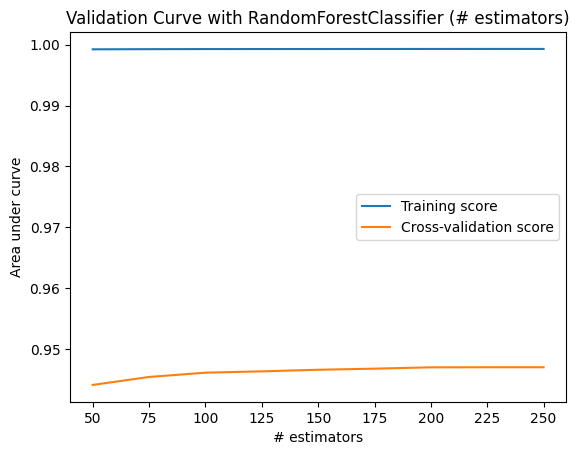

In [34]:
plt.figure()
plt.plot(param_range_n_estimators, np.mean(train_scores_n_estimators, axis=1), label="Training score")
plt.plot(param_range_n_estimators, np.mean(test_scores_n_estimators, axis=1), label="Cross-validation score")
plt.title("Validation Curve with RandomForestClassifier (# estimators)")
plt.xlabel("# estimators")
plt.ylabel("Area under curve")
plt.legend(loc="best")
plt.show()

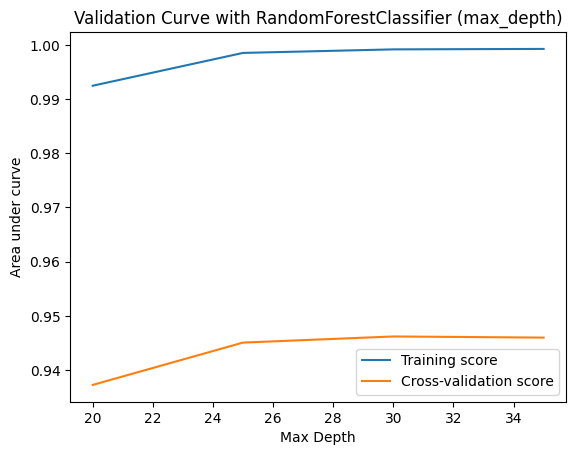

In [35]:
param_range_max_depth = np.arange(20, 40, 5)
train_scores_depth, test_scores_depth = validation_curve(
    RandomForestClassifier(random_state=0), X_train, E_train, 
    param_name="max_depth", param_range=param_range_max_depth,
    cv=5, scoring="roc_auc", n_jobs=-1)

plt.figure()
plt.plot(param_range_max_depth, np.mean(train_scores_depth, axis=1), label="Training score")
plt.plot(param_range_max_depth, np.mean(test_scores_depth, axis=1), label="Cross-validation score")
plt.title("Validation Curve with RandomForestClassifier (max_depth)")
plt.xlabel("Max Depth")
plt.ylabel("Area under curve")
plt.legend(loc="best")
plt.show()


In [36]:
param_range_min_samples_split = np.arange(2, 10, 2)
train_scores_min_samples_split, test_scores_min_samples_split = validation_curve(
    RandomForestClassifier(random_state=0), X_train, E_train, 
    param_name="min_samples_split", param_range=param_range_min_samples_split,
    cv=5, scoring="roc_auc", n_jobs=-1)

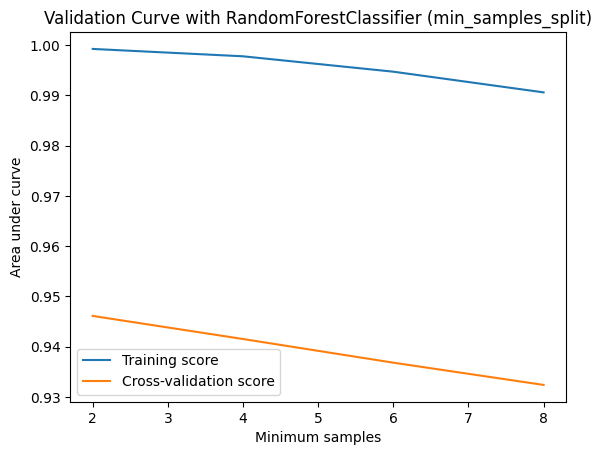

In [37]:
plt.figure()
plt.plot(param_range_min_samples_split, np.mean(train_scores_min_samples_split, axis=1), label="Training score")
plt.plot(param_range_min_samples_split, np.mean(test_scores_min_samples_split, axis=1), label="Cross-validation score")
plt.title("Validation Curve with RandomForestClassifier (min_samples_split)")
plt.xlabel("Minimum samples")
plt.ylabel("Area under curve")
plt.legend(loc="best")
plt.show()

Using these training curves we can see where the training score reaches 100%, the model can identify exactly the cases in the training set and separate them. Using the data on unseen data, is the validation score. 

The defaults used by random forest from sklearn seem to be optimal in the case of # estimators (100) or min_samples_split (2). But for max_depth we can reach the peak by setting this to 25.

# Survival modelling
Here we look at the survival modelling. I have choosen for the scikit-survival package. It was easy to install and plays noce with the the rest of the scikit-learn stack

In [38]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

y_train = Surv.from_arrays(E_train,T_train)
y_test = Surv.from_arrays(E_test,T_test)
y_full = Surv.from_arrays(E,T)

cph = CoxPHSurvivalAnalysis()
y_train = Surv.from_arrays(E_train, T_train)
cph.fit(X_train, y_train)

CoxPHSurvivalAnalysis()

## Applications for survival analysis

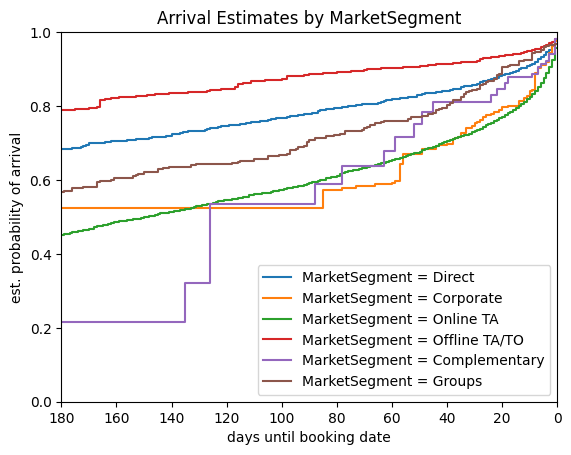

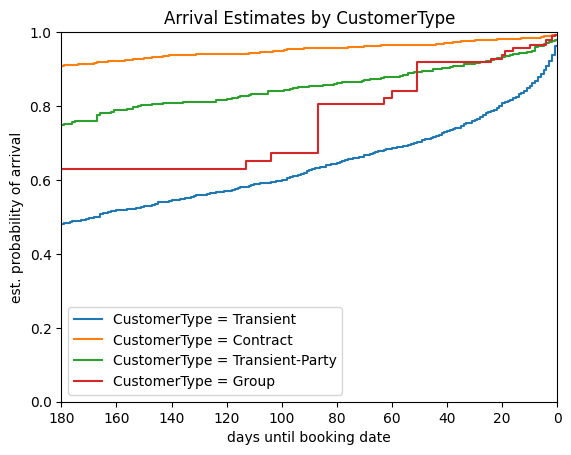

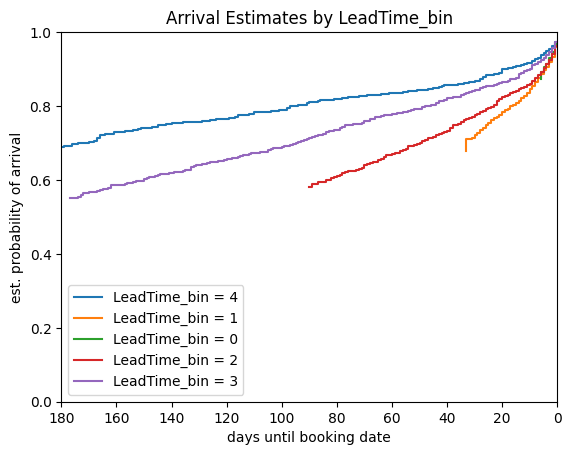

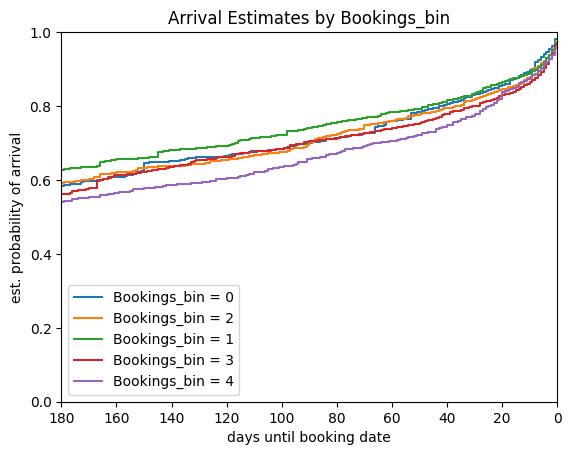

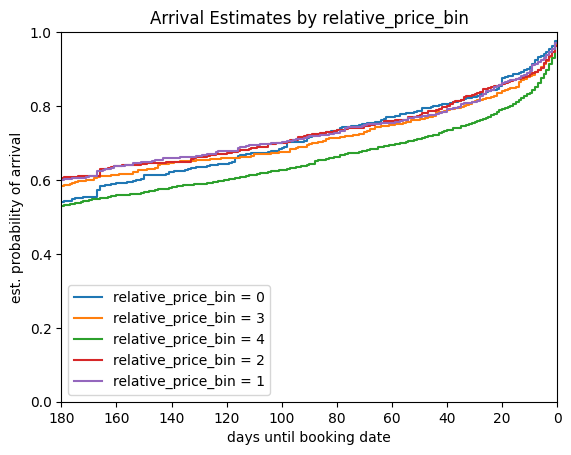

In [39]:

def plot_kaplan_meier(df, column_name, y_full):
    """
    Plots Kaplan-Meier estimator curves for different segments defined by a column in the DataFrame.

    Args:
    - df: DataFrame containing the data.
    - column_name: The name of the column based on which to segment the data.
    - y_full: DataFrame or structured array with 'event' and 'time' columns for Kaplan-Meier estimator.
    """
    for segment in df[column_name].unique():
        mask = df[column_name] == segment
        time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
            y_full["event"][mask],
            y_full["time"][mask],
            conf_type="log-log",
        )

        plt.step(time_treatment, survival_prob_treatment, where="post", label=f"{column_name} = {segment}")


    plt.ylim(0, 1)
    plt.xlim(180, 0)
    plt.ylabel("est. probability of arrival")
    plt.xlabel("days until booking date")
    plt.title(f"Arrival Estimates by {column_name}")
    plt.legend(loc="best")
    plt.show()


plot_kaplan_meier(df_h1, 'MarketSegment', y_full)
plot_kaplan_meier(df_h1, 'CustomerType', y_full)
plot_kaplan_meier(df_h1, 'LeadTime_bin', y_full)
plot_kaplan_meier(df_h1, 'Bookings_bin', y_full)
plot_kaplan_meier(df_h1, 'relative_price_bin', y_full)
#LeadTime, relative_price




## Results

We will use the area under curve calculation as our primary metric because this translates across the different kinds of models. Remember, a random model would score 0.5, and a perfect model scores 1. The random forest scores quite well, with a score of 0.866.

Here you can find different examples of models from survival analysis. We have also calculated the mean AUC. This is because the models are scores not on the 'does the customer cancel over the whole reservation period?', but they are scored for the question: 'Does the customer cancel in the next 7 days?'

In [40]:
clf_md25 = RandomForestClassifier(max_depth=25, random_state=0)
clf_md25.fit(X_train, E_train)

y_pred =  clf_md25.predict(X_test)
rf_score = roc_auc_score(y_pred, E_test)
rf_score

0.9073941448773479

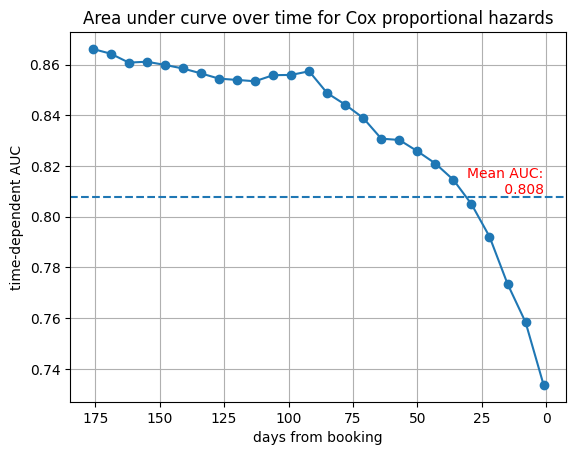

In [41]:
def visualise_risk_graph(estimator, model_name):
    time_steps = np.arange(1,180, 7)
    risk_scores = estimator.predict(X_test)
    auc_over_time, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_scores, time_steps)
    
    plt.plot(time_steps, auc_over_time, marker="o")

    plt.axhline(mean_auc, linestyle="--")
    
    # Text annotation for mean AUC
    text_x = time_steps[0]  # Position text at the right end of the plot
    text_y = mean_auc  # Align text vertically with the horizontal line
    plt.text(text_x, text_y, f'Mean AUC:\n {mean_auc:.3f}', va='bottom', ha='right', fontsize=10, color='r')  # Adjust text properties as needed

    plt.gca().invert_xaxis()
    
    plt.xlabel("days from booking")
    plt.ylabel("time-dependent AUC")
    plt.title(f"Area under curve over time for {model_name}")
    plt.grid(True)

visualise_risk_graph(cph, "Cox proportional hazards")

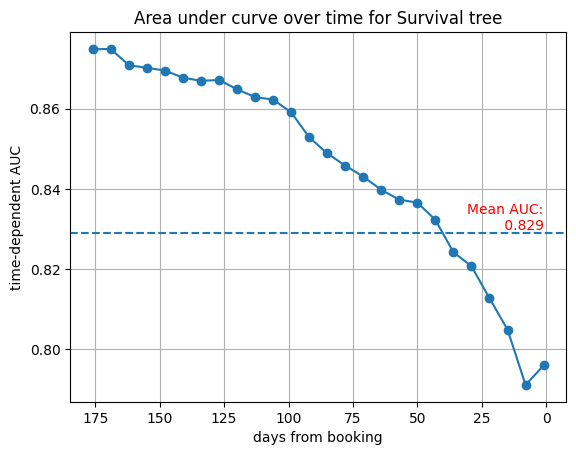

In [42]:
from sksurv.tree import SurvivalTree # A single tree in a survival model 
SurvTree = SurvivalTree().fit(X_train, y_train)
visualise_risk_graph(SurvTree, "Survival tree")

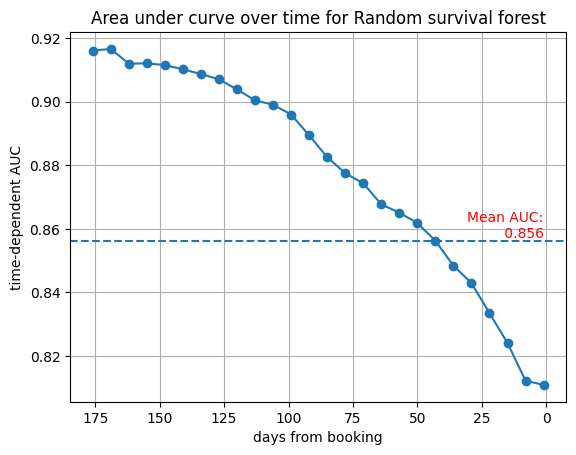

In [43]:
from sksurv.ensemble import RandomSurvivalForest # A random forest in a survival model 
SurvRF = RandomSurvivalForest().fit(X_train, y_train)
visualise_risk_graph(SurvRF, "Random survival forest")

Using these models also give us insight to the most driving factor to forecast cancellation, just as the random forest model does. The largest insight is that lead time is still relevant, but when we compensate for that, Market segment and customer type are even more influential

In [44]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

# These lines are commented out, because the analysis runs very long
# scores = fit_and_score_features(X_train.values, y_train)
# pd.Series(scores, index=X_train.columns).sort_values(ascending=False)
# Main predictors are: MarketSegment, CustomerType, LeadTime

Table with results

In [45]:
df = pd.DataFrame([{'Model:': "Random Forest classifier", "AUC:": 0.908},
{'Model:': "Cox proportional hazards", "AUC:": 0.806},
{'Model:': "Survival tree", "AUC:": 0.824},
{'Model:': "Survival random forest", "AUC:": 0.854}
                  ])
df

,Model:,AUC:
0,Random Forest classifier,0.908
1,Cox proportional hazards,0.806
2,Survival tree,0.824
3,Survival random forest,0.854


## Discussion

The analysis indicates that both the linear Cox hazards model and the survival tree performed competitively with the random forest, particularly considering the added complexity of predicting future events within the booking period. These results are promising, highlighting the potential for practical applications in business, such as enhancing occupancy forecasts, implementing timely strategies to reduce customer churn, and segmenting customers based on churn risk to focus on retention efforts. Optimizing occupancy, especially during peak seasons, is another notable benefit.

## Future work

The utility of these models as tools for data scientists is evident, and they have proven to be user-friendly in this context. Future research could explore:

- Analyzing the second dataset to validate these findings.
- Improving the survival tree model's accuracy by fine-tuning hyperparameters, such as tree depth or minimum leaf size, to better generalize the model.

One of the improvements we could make is some of the other survival models would not work out of the box. For example, the support vector machine could not deal with arrivals on the same date, and the cox elasticnet (l1 or l2 regularization) had a score which was 0.5, just as good as a random model.